In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import KShape
import numpy as np
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
from matplotlib import pyplot as plt
import math

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_z = pd.read_parquet('../../data/pre_processed/covid_cases_z_trans.parquet')

# Forecasting with K_shape

This notebook was used to test K-shape clustering in combinantion with forecasting. 

In [3]:
#Function used to perform prediction. Input: forecasting model, traning dataframe, test dataframe, 
#list of features, and number of predictions, default 8. Returns dataframe with same format as
#additional test_df, with an additional column with predictions.

def predict(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    #Generating an encoder for country feature by converting country string to int value
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    #Dataframe with all features
    x_training_df = training_df[feature_list].copy()
    #Dataframe with all cases
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end and predict (10-10-2020->17-10-2020)
        features_df = test_df[feature_list][start_period:end_period].copy()
        #Generating an encoder for country feature by converting country string to int value
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    df_result = test_df.assign(Predicted=prediction_list)
    return df_result

In [4]:
#Function that computes a SMAPE. Input: dataframe including true and prediction,
#true_column that specifies which column of df holds the true values and 
#pred_column that specifies which column of df hold the predicted values
def SMAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()
    return 1/len(true_list)*np.sum(2*np.abs(pred_list-true_list)/(np.abs(true_list)+np.abs(pred_list))*100)

In [5]:
#Function computes an additional column which sums predicted value together to form an accumulated
#prediction. Prediction for day 0 is summed to the known total cases the day before.
#Input: dataframe contanint all data on test country and dataframe including predictions produced
#by def forecast. 
def accumulated_dataframe_column(df_test_country,CB_df):
    test_start_value = df_test_country.loc[df_test_country.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    accumulated_list = [math.floor(test_start_value+CB_df['Predicted'][0])]
    for i in range(1,len(CB_df)):
        accumulated_list.append(math.floor(accumulated_list[i-1]+CB_df['Predicted'][i]))
    df_result = CB_df.copy()
    df_result['Accumulated_Prediction'] = accumulated_list
    return df_result

## Creating cluster, k-shape

K-Shape is very similar to k-means. The difference is that the k-shape algorithm leverages the knowledge that our data point is time series. With time series, we have more room to operate.

K-shape is a partitional clustering method with an iterative refinement procedure much like K-means. However, it is differentiated from K-means because the algorithm leverages the knowledge that the data points are a time series. With time series, one have more room to operate. During the refinement procedure, the algorithm is able to minimize the sum of squared distances and manages to both (i) produce homogeneous and well-separated clusters, and (ii) scale linearly with the number of time series. Initially, the time series are randomly assigned into clusters. 

The algorithm stops either when (i) there are no changes in cluster memberships, or (ii) the maximum number of iterations allowed is reached. The group have been using the K-shape implementation belonging to the python package tslearn, which provides machine learning tools for analysis of time series. 

Link to the implementation package from tslearn:
https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.KShape.html

Source: 
J. Paparrizos. and L. Gravano. (2015). k-Shape: Efficient and Accurate Clustering of Time Series. Retrieved from: http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf

In [6]:
df_trans = df_z.T

In [7]:
df_array = df_trans.to_numpy()

In [8]:
df_array.shape

(83, 201)

In [9]:
seed = 42
np.random.seed(seed)

ks = KShape(n_clusters=4, n_init=100, random_state=seed)
y_pred = ks.fit_predict(df_array)

In [10]:
df_kshape_z_0=df_trans.loc[y_pred==0].transpose()
df_kshape_z_1=df_trans.loc[y_pred==1].transpose()
df_kshape_z_2=df_trans.loc[y_pred==2].transpose()
df_kshape_z_3=df_trans.loc[y_pred==3].transpose()

## Selecting test countries

In [11]:
df_forecasting = pd.read_parquet('../../data/forecasting_format/dataframe_forecasting_with_features.parquet')

In [12]:
Algeria_df = df_forecasting [df_forecasting['Country'].isin(['Algeria'])]

In [13]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [14]:
Belgium_df = df_forecasting[df_forecasting['Country'].isin(['Belgium'])]

In [15]:
test_2_df =  Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [16]:
Bangladesh_df = df_forecasting[df_forecasting['Country'].isin(['Bangladesh'])]

In [17]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [18]:
Croatia_df = df_forecasting[df_forecasting['Country'].isin(['Croatia'])]

In [19]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [20]:
selected_clusters = []
test_countries_not_used = []

In [21]:
def forecasting(k_shape_countries_list,k_shape_df,country_df,test_df):
    k_shape_df = df_forecasting[df_forecasting['Country'].isin(k_shape_countries_list)]
    k_shape_training_df = k_shape_df[(k_shape_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (k_shape_df.index.date <= datetime.date(2020, 9, 9))].copy()
    feature_list = ['Country','Month','Day','prev_case']
    params= {'iterations': 5000, 'silent': True}
    model = CatBoostRegressor(**params)
    k_shape_CB_df = predict(model=model, training_df=k_shape_training_df.copy(), 
                                                             test_df=test_df.copy(),
                                                             feature_list=feature_list)
    k_shape_CB_df = accumulated_dataframe_column(country_df,k_shape_CB_df)
    return k_shape_CB_df

## Forecasting, cluster with Algeria

Select correct cluster

In [22]:
if 'Algeria' in df_kshape_z_0.columns and 'df_kshape_z_0' not in selected_clusters:
    k_shape_1_df = df_kshape_z_0.copy()
    selected_clusters.append('df_kshape_z_0')
elif 'Algeria' in df_kshape_z_1.columns and 'df_kshape_z_1' not in selected_clusters:
    k_shape_1_df = df_kshape_z_1.copy()
    selected_clusters.append('df_kshape_z_1')
elif 'Algeria' in df_kshape_z_2.columns and 'df_kshape_z_2' not in selected_clusters:
    k_shape_1_df = df_kshape_z_2.copy()
    selected_clusters.append('df_kshape_z_2')
elif 'Algeria' in df_kshape_z_3.columns and 'df_kshape_z_3' not in selected_clusters:
    k_shape_1_df = df_kshape_z_3.copy()
    selected_clusters.append('df_kshape_z_3')
else:
    test_countries_not_used.append('Algeria')

In [23]:
print(selected_clusters)
print(test_countries_not_used)

['df_kshape_z_0']
[]


In [24]:
if 'Algeria' not in test_countries_not_used:
    k_shape_1_countries_list = list(k_shape_1_df.columns)
    k_shape_1_CB_df = forecasting(k_shape_1_countries_list,k_shape_1_df,Algeria_df,test_1_df)

In [25]:
print(k_shape_1_countries_list)

['Algeria', 'Argentina', 'Australia', 'Bolivia', 'Bulgaria', 'Colombia', 'Costa Rica', 'Dominican Republic', 'El Salvador', 'Ethiopia', 'India', 'Indonesia', 'Iraq', 'Israel', 'Japan', 'Kazakhstan', 'Kenya', 'Malawi', 'Mexico', 'Mozambique', 'Nepal', 'Panama', 'Peru', 'Philippines', 'Romania', 'Rwanda', 'South Africa', 'Ukraine', 'Vietnam', 'Zambia', 'Zimbabwe']


In [26]:
print(len(k_shape_1_countries_list))

31


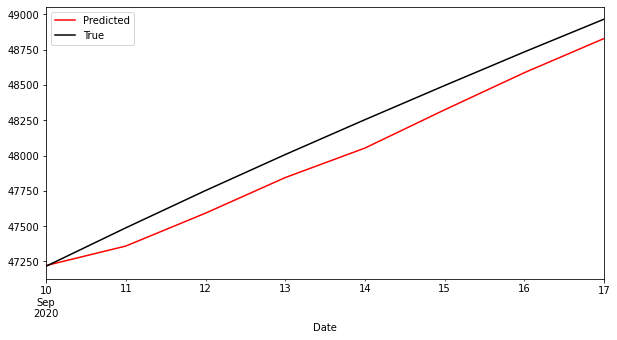

In [27]:
k_shape_1_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE k_shape 1:

In [28]:
round(SMAPE(k_shape_1_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2892

# Cluster with Belgium

Select correct cluster

In [29]:
if 'Belgium' in df_kshape_z_0.columns and 'df_kshape_z_0' not in selected_clusters:
    k_shape_2_df = df_kshape_z_0.copy()
    selected_clusters.append('df_kshape_z_0')
elif 'Belgium' in df_kshape_z_1.columns and 'df_kshape_z_1' not in selected_clusters:
    k_shape_2_df = df_kshape_z_1.copy()
    selected_clusters.append('df_kshape_z_1')
elif 'Belgium' in df_kshape_z_2.columns and 'df_kshape_z_2' not in selected_clusters:
    k_shape_2_df = df_kshape_z_2.copy()
    selected_clusters.append('df_kshape_z_2')
elif 'Belgium' in df_kshape_z_3.columns and 'df_kshape_z_3' not in selected_clusters:
    k_shape_2_df = df_kshape_z_3.copy()
    selected_clusters.append('df_kshape_z_3')
else:
    test_countries_not_used.append('Belgium')

In [30]:
print(selected_clusters)
print(test_countries_not_used)

['df_kshape_z_0', 'df_kshape_z_3']
[]


In [31]:
if 'Belgium' not in test_countries_not_used:
    k_shape_2_countries_list = list(k_shape_2_df.columns)
    k_shape_2_CB_df = forecasting(k_shape_2_countries_list,k_shape_2_df,Belgium_df,test_2_df)

In [32]:
print(k_shape_2_countries_list)

['Austria', 'Belgium', 'Canada', 'Cuba', 'Denmark', 'Estonia', 'Fiji', 'Finland', 'Iceland', 'Ireland', 'Latvia', 'Malaysia', 'New Zealand', 'Norway', 'Slovenia', 'Switzerland', 'Thailand', 'Turkey', 'United Kingdom', 'Uruguay']


In [33]:
print(len(k_shape_2_countries_list))

20


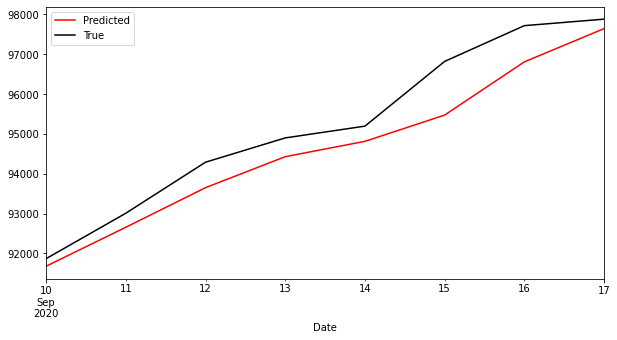

In [34]:
k_shape_2_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE k_shape 2:

In [35]:
round(SMAPE(k_shape_2_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.593

## Cluster with Bangladesh

Select correct cluster

In [36]:
if 'Bangladesh' in df_kshape_z_0.columns and 'df_kshape_z_0' not in selected_clusters:
    k_shape_3_df = df_kshape_z_0.copy()
    selected_clusters.append('df_kshape_z_0')
elif 'Bangladesh' in df_kshape_z_1.columns  and 'df_kshape_z_1' not in selected_clusters:
    k_shape_3_df = df_kshape_z_1.copy()
    selected_clusters.append('df_kshape_z_1')
elif 'Bangladesh' in df_kshape_z_2.columns and 'df_kshape_z_2' not in selected_clusters:
    k_shape_3_df = df_kshape_z_2.copy()
    selected_clusters.append('df_kshape_z_2')
elif 'Bangladesh' in df_kshape_z_3.columns  and 'df_kshape_z_3' not in selected_clusters:
    k_shape_3_df = df_shape_z_3.copy()
    selected_clusters.append('df_shape_z_3')
else:
    test_countries_not_used.append('Bangladesh')

In [37]:
print(selected_clusters)
print(test_countries_not_used)

['df_kshape_z_0', 'df_kshape_z_3', 'df_kshape_z_2']
[]


In [38]:
if 'Bangladesh' not in test_countries_not_used:
    k_shape_3_countries_list = list(k_shape_3_df.columns)
    k_shape_3_CB_df = forecasting(k_shape_3_countries_list,k_shape_3_df,Bangladesh_df,test_3_df)

In [39]:
print(k_shape_3_countries_list)

['Bahrain', 'Bangladesh', 'Belarus', 'Chile', 'Ghana', 'Iran', 'Kuwait', 'Nigeria', 'Oman', 'Pakistan', 'Poland', 'Qatar', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia', 'Sri Lanka', 'Sweden', 'Togo', 'United Arab Emirates', 'United States']


In [40]:
print(len(k_shape_3_countries_list))

21


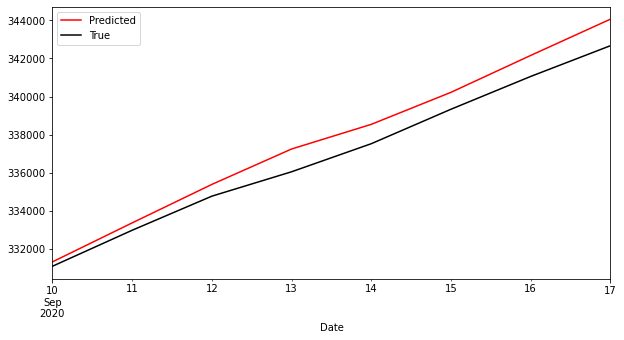

In [41]:
k_shape_3_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE k_shape 3:

In [42]:
round(SMAPE(k_shape_3_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2522

## Cluster with Croatia

Select correct cluster

In [43]:
if 'Croatia' in df_kshape_z_0.columns and 'df_kshape_z_0' not in selected_clusters:
    k_shape_4_df = df_kshape_z_0.copy()
    selected_clusters.append('df_kshape_z_0')
elif 'Croatia' in df_kshape_z_1.columns and 'df_kshape_z_1' not in selected_clusters:
    k_shape_4_df = df_kshape_z_1.copy()
    selected_clusters.append('df_kshape_z_1')
elif 'Croatia' in df_kshape_z_2.columns and 'df_kshape_z_2' not in selected_clusters:
    k_shape_4_df = df_kshape_z_2.copy()
    selected_clusters.append('df_kshape_z_2')
elif 'Croatia' in df_kshape_z_3.columns and 'df_kshape_z_3' not in selected_clusters:
    k_shape_4_df = df_kshape_z_3.copy()
    selected_clusters.append('df_kshape_z_3')
else:
    test_countries_not_used.append('Croatia')

In [44]:
print(selected_clusters)
print(test_countries_not_used)

['df_kshape_z_0', 'df_kshape_z_3', 'df_kshape_z_2', 'df_kshape_z_1']
[]


In [45]:
if 'Croatia' not in test_countries_not_used:
    k_shape_4_countries_list = list(k_shape_4_df.columns)
    k_shape_4_CB_df = forecasting(k_shape_4_countries_list,k_shape_4_df,Croatia_df,test_4_df)

In [46]:
print(k_shape_4_countries_list)

['Croatia', 'Czech Republic', 'Greece', 'Hungary', 'Malta', 'Morocco', 'Myanmar', 'Paraguay', 'Slovakia', 'South Korea', 'Tunisia']


In [47]:
print(len(k_shape_4_countries_list))

11


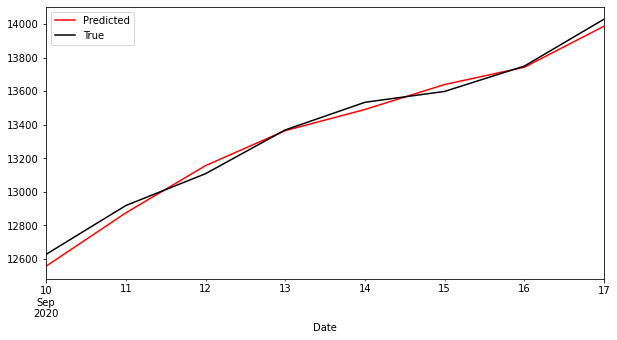

In [48]:
k_shape_4_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(10,5))

SMAPE k_shape 4:

In [49]:
round(SMAPE(k_shape_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2838

Total SMAPE

In [50]:
round(SMAPE(k_shape_1_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(SMAPE(k_shape_2_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(SMAPE(k_shape_3_CB_df,'cases_tot','Accumulated_Prediction'),4)+round(SMAPE(k_shape_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

1.4182